# Import Relevant Packages

In [1]:
import os

import evaluate
import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets import Dataset, load_dataset
from PIL import Image
from transformers import (
    Trainer,
    TrainingArguments,
    ViTForImageClassification,
    ViTImageProcessor,
)

accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

if torch.cuda.is_available():
    os.environ["CUDA_VISIBLE_DEVICES"] = "7"
elif torch.backends.mps.is_available():
    os.environ["MPS_DEVICE"] = "1"
else:
    print("No GPU available... Using CPU")

# Model configs
model_path = "google/vit-base-patch16-224-in21k"
batch_size = 256
epochs = 5
lr = 2e-4
num_workers = 8

/home/public/avaishna/leaf_classification/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load dataset

In [2]:
data = load_dataset(
    "parquet",
    data_files=[
        "https://huggingface.co/datasets/avaishnav/Indian-plant-leaves-species/resolve/refs/convert/parquet/default/train/0000.parquet",
        "https://huggingface.co/datasets/avaishnav/Indian-plant-leaves-species/resolve/refs/convert/parquet/default/train/0001.parquet",
    ],
    split="train",
)

data = data.train_test_split(test_size=0.2, stratify_by_column="label")
print(data)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 473
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 119
    })
})


# Data type

Check the data type and size of the features in the dataset

In [3]:
first_data = data["train"][0]
print(type(first_data["image"]))
print(type(first_data["label"]))

# Print the shape of the image
print(first_data["image"].size)
print(first_data["label"])


<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'int'>
(6000, 4000)
11


# Explore the labels in the dataset

In [4]:
def class_names(dataset: Dataset):
    """
    Get the class names from the dataset.

    Args:
        dataset (Dataset): The dataset to get the class names from.

    Returns:
        None
    """
    labels = dataset["train"].features["label"].names
    id2label = {i: label for i, label in enumerate(labels)}

    for key, value in id2label.items():
        print(f"Id: {key}, Label: {value}")

    return id2label


id2label = class_names(data)

Id: 0, Label: Alstonia Scholaris
Id: 1, Label: Arjun
Id: 2, Label: Bael
Id: 3, Label: Basil
Id: 4, Label: Chinar
Id: 5, Label: Guava
Id: 6, Label: Jamun
Id: 7, Label: Jatropha
Id: 8, Label: Lemon
Id: 9, Label: Mango
Id: 10, Label: Pomegranate
Id: 11, Label: Pongamia Pinnata


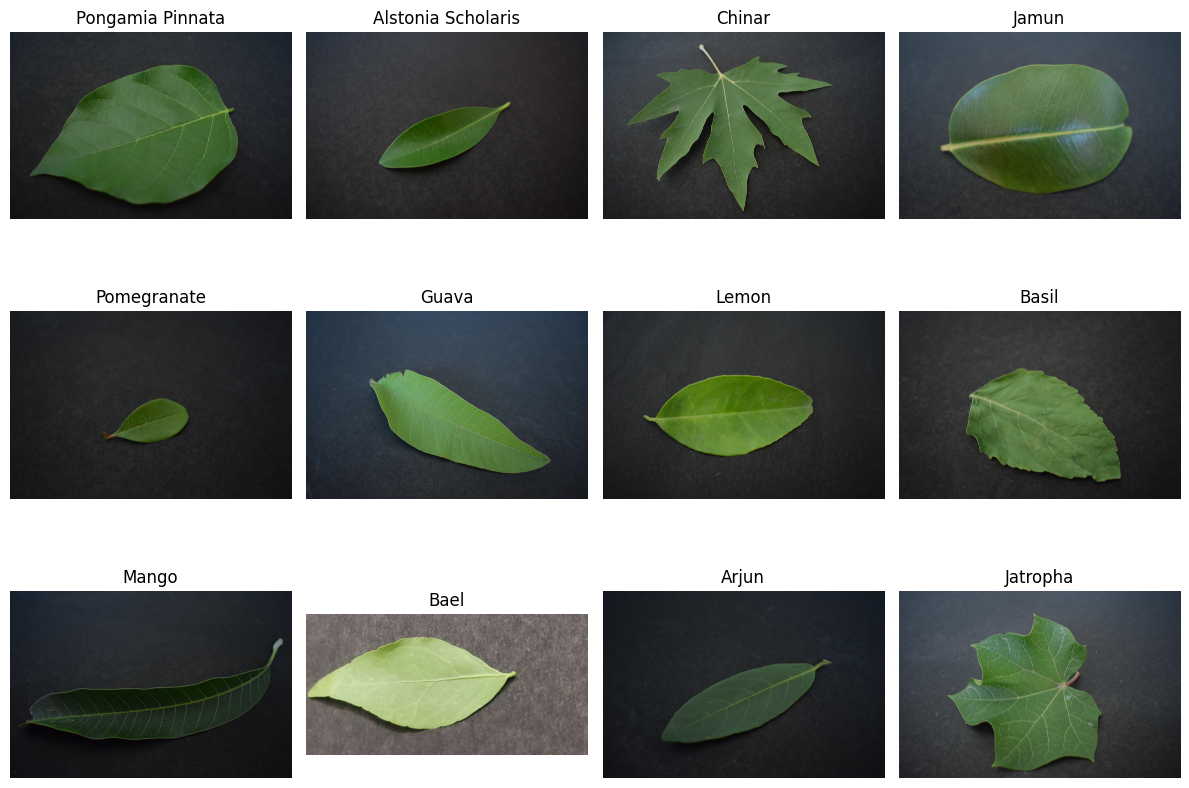

In [5]:
def visualize_data(dataset, id2label, ncols=4):
    """
    Visualize one sample from each class in the dataset with its label.
    Args:
        dataset: torch.utils.data.Dataset or HuggingFace Dataset (expects __getitem__ to return (image, label) or dict)
        id2label: dict mapping label indices to class names
        ncols: number of columns in the plot grid
    """
    seen = set()
    samples = []
    for item in dataset:
        # Handle raw HuggingFace dataset (dict)
        if isinstance(item, dict):
            img = item["image"]
            label = item["label"]
        else:
            img, label = item
        if label not in seen:
            samples.append((img, label))
            seen.add(label)
        if len(seen) == len(id2label):
            break
    n_classes = len(samples)
    nrows = int(np.ceil(n_classes / ncols))
    plt.figure(figsize=(ncols * 3, nrows * 3))
    for i, (img, label) in enumerate(samples):
        plt.subplot(nrows, ncols, i + 1)
        # Handle PIL Image
        if isinstance(img, Image.Image):
            img_np = np.array(img)
        # Handle torch.Tensor
        elif isinstance(img, torch.Tensor):
            img_np = img.numpy()
            if img_np.shape[0] in [1, 3]:  # C,H,W -> H,W,C
                img_np = np.transpose(img_np, (1, 2, 0))
            if img_np.shape[-1] == 1:
                img_np = img_np.squeeze(-1)
        # Handle numpy array
        elif isinstance(img, np.ndarray):
            img_np = img
        else:
            # Fallback: try to convert to numpy array
            img_np = np.array(img)
        plt.imshow(img_np)
        plt.title(id2label[label])
        plt.axis("off")
    plt.tight_layout()
    plt.show()


visualize_data(data["train"], id2label)


In [6]:
processor = ViTImageProcessor.from_pretrained(model_path)
processor

ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [7]:
example_batch = processor(data["train"][0]["image"], return_tensors="pt")
print(example_batch)
print(f"Example batch: {example_batch['pixel_values'].shape}")
print(f"Image size: {data['train'][0]['image'].size}")
print(f"Label: {data['train'][0]['label']}")

{'pixel_values': tensor([[[[-0.7882, -0.7961, -0.7882,  ..., -0.7647, -0.7725, -0.7882],
          [-0.7804, -0.7882, -0.7804,  ..., -0.7647, -0.7725, -0.7804],
          [-0.7569, -0.7804, -0.7804,  ..., -0.7725, -0.7725, -0.7804],
          ...,
          [-0.8510, -0.8431, -0.8431,  ..., -0.8353, -0.8431, -0.8510],
          [-0.8510, -0.8510, -0.8431,  ..., -0.8353, -0.8431, -0.8510],
          [-0.8510, -0.8510, -0.8510,  ..., -0.8353, -0.8431, -0.8510]],

         [[-0.7333, -0.7412, -0.7333,  ..., -0.7098, -0.7176, -0.7333],
          [-0.7412, -0.7333, -0.7255,  ..., -0.7098, -0.7176, -0.7333],
          [-0.7255, -0.7333, -0.7255,  ..., -0.7176, -0.7176, -0.7255],
          ...,
          [-0.8667, -0.8588, -0.8588,  ..., -0.8353, -0.8431, -0.8510],
          [-0.8667, -0.8667, -0.8588,  ..., -0.8353, -0.8431, -0.8510],
          [-0.8667, -0.8667, -0.8667,  ..., -0.8353, -0.8431, -0.8510]],

         [[-0.6706, -0.6784, -0.6706,  ..., -0.6314, -0.6392, -0.6549],
          [-0

In [8]:
def preprocess(example):
    """
    Run the ViT image processor on a batch of PIL images.

    HF `datasets.map(batched=True)` passes in a *dict of lists*.
    We run the processor on the whole list, then return **one item
    per original example** so the dataset stays aligned.

    Returns
    -------
    dict with keys:
        pixel_values : list[Tensor]  # each of shape (3, 224, 224)
        label        : original labels (unchanged)
    """
    inputs = processor(example["image"], return_tensors="pt")["pixel_values"]
    return {"pixel_values": [x for x in inputs], "labels": example["label"]}


prepared_data_train = data["train"].with_transform(preprocess)
prepared_data_test = data["test"].with_transform(preprocess)

print(
    f"Prepared data first sample train: pixel_values: {prepared_data_train[0]['pixel_values'].shape}, labels: {prepared_data_train[0]['labels']}"
)

Prepared data first sample train: pixel_values: torch.Size([3, 224, 224]), labels: 11


In [9]:
def collate_fn(batch):
    """
    Collate the batch.

    Args:
        batch (list): List of dictionaries containing the pixel values and labels.

    Returns:
        dict: Dictionary containing the collated batch.
    """
    return {
        "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
        "labels": torch.tensor([x["labels"] for x in batch]),
    }


In [10]:
def compute_metrics(p):
    """
    Compute metrics for the model.

    Args:
        p (PredictionOutput): Prediction output from the model.

    Returns:
        dict: Dictionary containing the metrics.
    """

    preds = p.predictions.argmax(axis=-1)
    labels = p.label_ids

    acc = accuracy.compute(predictions=preds, references=labels)
    prec = precision.compute(
        predictions=preds, references=labels, average="macro"
    )  # macro for multiclass
    rec = recall.compute(
        predictions=preds, references=labels, average="macro"
    )  # macro for multiclass
    f1_metric = f1.compute(
        predictions=preds, references=labels, average="macro"
    )  # macro for multiclass
    return {
        "accuracy": acc["accuracy"],
        "precision": prec["precision"],
        "recall": rec["recall"],
        "f1": f1_metric["f1"],
    }


In [11]:
training_args = TrainingArguments(
    run_name="vit-base-plants-demo-v2",
    output_dir="./experiments",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    eval_strategy="steps",
    logging_strategy="steps",
    num_train_epochs=epochs,
    # fp16=True,
    save_steps=100,
    eval_steps=100,
    logging_steps=10,
    learning_rate=lr,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True,
    dataloader_num_workers=num_workers,
)


In [12]:
labels = data["train"].features["label"].names

model = ViTForImageClassification.from_pretrained(
    model_path,
    num_labels=len(labels),
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=prepared_data_train,
    eval_dataset=prepared_data_test,
    compute_metrics=compute_metrics,
    # processing_class=processor,
)


In [14]:
# Train the model
print("Training the model...")
train_results = trainer.train()

# Save the trained model
print("Saving the trained model...")
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Training the model...


2025/06/03 14:35:48 ERROR failed to get logger path error="error creating log directory: mkdir /home/grad/masters/2025/avaishna/.cache/wandb/logs: permission denied"
2025/06/03 14:35:48 INFO Will exit if parent process dies. ppid=823356
2025/06/03 14:35:48 INFO server is running addr=127.0.0.1:39839
2025/06/03 14:35:48 INFO connection: ManageConnectionData: new connection created id=127.0.0.1:44200


wandb: Currently logged in as: prototype-anugrah to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
2025/06/03 14:35:49 INFO handleInformInit: received streamId=k2oa48sp id=127.0.0.1:44200
2025/06/03 14:35:49 INFO handleInformInit: stream started streamId=k2oa48sp id=127.0.0.1:44200


Step,Training Loss,Validation Loss


Saving the trained model...
***** train metrics *****
  epoch                    =         5.0
  total_flos               = 170697440GF
  train_loss               =      1.8972
  train_runtime            =  0:06:50.31
  train_samples_per_second =       5.764
  train_steps_per_second   =       0.024


In [15]:
# Evaluate the model
print("Evaluating the model...")
metrics = trainer.evaluate(prepared_data_test)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

Evaluating the model...


***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =     0.9748
  eval_f1                 =     0.9748
  eval_loss               =     1.5074
  eval_precision          =     0.9785
  eval_recall             =      0.975
  eval_runtime            = 0:00:35.16
  eval_samples_per_second =      3.384
  eval_steps_per_second   =      0.028


In [16]:
predictions = trainer.predict(prepared_data_test)
pred_labels = predictions.predictions.argmax(axis=-1)
mapped_preds = [id2label[pred] for pred in pred_labels]
actual_labels = [
    prepared_data_test.features["label"].names[prepared_data_test[i]["labels"]]
    for i in range(prepared_data_test.num_rows)
]
print(f"Predicted labels: {mapped_preds[:10]}")
print(f"Actual labels: {actual_labels[:10]}")


Predicted labels: ['Pomegranate', 'Jamun', 'Alstonia Scholaris', 'Bael', 'Pomegranate', 'Arjun', 'Basil', 'Alstonia Scholaris', 'Mango', 'Pongamia Pinnata']
Actual labels: ['Pomegranate', 'Jamun', 'Alstonia Scholaris', 'Bael', 'Pomegranate', 'Arjun', 'Basil', 'Alstonia Scholaris', 'Mango', 'Pongamia Pinnata']


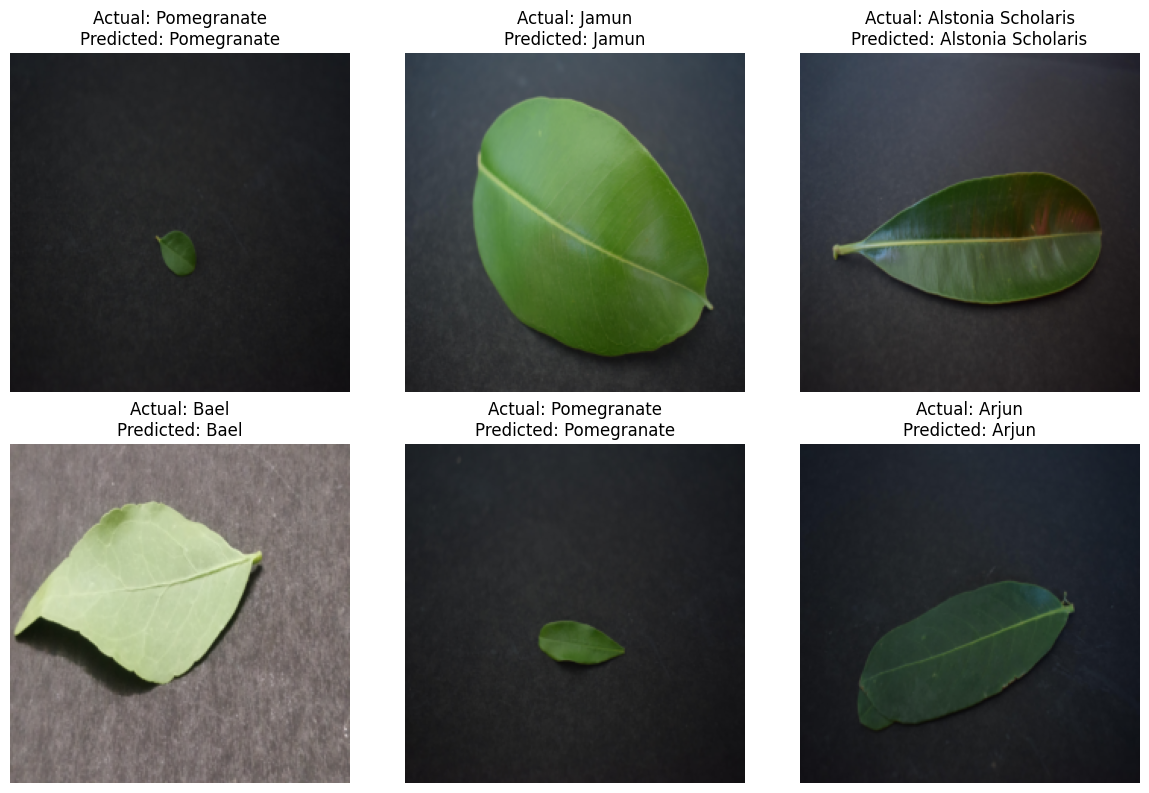

In [17]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axes = axs.flatten()

for idx in range(6):
    # If you have the original image, use it. Otherwise, reconstruct from pixel_values:
    # print(prepared_data_test[idx])
    image = prepared_data_test[idx]["pixel_values"]

    image = image * torch.tensor(std)[:, None, None] + torch.tensor(mean)[:, None, None]
    image = image.clamp(0, 1)
    # Convert to numpy for plotting
    image_np = image.numpy()
    # If image is (C, H, W), transpose to (H, W, C)
    if image_np.ndim == 3 and image_np.shape[0] in [1, 3]:
        image_np = image_np.transpose(1, 2, 0)
    # If image is (H, W, 1), squeeze last dimension for grayscale
    if image_np.ndim == 3 and image_np.shape[2] == 1:
        image_np = image_np.squeeze(-1)

    axes[idx].imshow(image_np)
    axes[idx].set_title(f"Actual: {actual_labels[idx]}\nPredicted: {mapped_preds[idx]}")
    axes[idx].axis("off")

plt.tight_layout()
plt.show()
